# DQN(Deep Q-Network)

- DQN이전 CNN이 아닌 AutoEncoder를 이용한 사례가 있음
    - 논문 : Deep auto-encoder neural networks in reinforcement learning - Sascha Lange and Martin Riedmiller(https://ieeexplore.ieee.org/document/5596468)
    - AutoEncoder를 일종의 dimenstion reduction으로 사용함
    - 학습된 latent variable(900 -> 2)으로 policy을 학습
    
### CNN
- 화면으로부터 direct로 학습

### Experience replay
- Sample들의 상관관계를 없애는 방법
- 일정한 크기를 갖는 mem(FIFO)

### Online Learning with Stochastic gradient descent
- 고정된 policy를 사용하지 않음
- 큐함수에 대한 $\epsilon$-greedy
- $\epsilon$-greedy policy로 탐험 reply mem에서 추출한 mini-batch로 큐함수를 업데이트

## 학습과정
### 1. Exploration
- policy는 큐함수에 대한 $\epsilon$-greedy
- $\epsilon$은 time step에 따라 decay, 1에서 시작 -> 0.1까지 decay, 0.1 유지

### 2. Sample 저장
- 에이전트는 $\epsilon$-greedy policy에 따라서 [s, a, r, s']을 생성하고 reply mem에 append

### 3. random sampling으로 학습
- 미니배치 32
- 샘플로부터 target값과 prediction의 값을 구함
    - MSE : $(target - prediction)^2$
    - Target : $reward + \gamma \ max_{a'} q_{\theta} (s', a)$
    - Prediction : $q_{\theta}(s, a)$
- MSE error에 대한 gradient backpropagation설정

## DQN 모형 설계 및 학습

### 1. Import Libs

In [1]:
import os
import datetime
import gym
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
from keras.layers import Dense
from keras.optimizers import Adam
from keras.models import Sequential

Using TensorFlow backend.


### 2. Model Define

In [2]:
plt.style.use('ggplot')
np.random.seed(123)
EPISODES = 300
global_steps = 0

class DQNAgent:
    def __init__(self, state_size, action_size):
        self.render = False
        self.load_model = False
        
        # 상태와 행동의 크기를 정의
        self.state_size = state_size
        self.action_size = action_size
        
        # DQN 하이퍼파라미터
        self.discount_factor = 0.99
        self.learning_rate = 0.001
        self.epsilon = 1.0
        self.epsilon_decay = 0.999
        self.epsilon_min = 0.01
        self.batch_size = 64
        self.train_start = 1000
        
        # 리플라이 메모리
        self.memory = deque(maxlen=2000)
        
        # 모델과 타깃 모델 생성dones
        self.model = self.build_model()
        self.target_model = self.build_model()
        
        # 타겟 모델 초기화
        self.update_target_model()
        
        if self.load_model:
            self.model.load_model.load_weights('./save_model/cartpole_dqn_trained.h5')
            
            
    def build_model(self):
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation='relu',
                       kernel_initializer='he_uniform'))
        model.add(Dense(24, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(self.action_size, activation='linear', kernel_initializer='he_uniform'))
        model.summary()
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        return model
    
    
    # 타깃 모델을 모델의 가중치로 업데이트
    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())
    
    
    # 입실론 탐욕 정책으로 행동을 선택
    def get_action(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        else:
            q_value = self.model.predict(state)
            return np.argmax(q_value[0])
        
    # 리플라이 메모리 설정
    def append_sample(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        
        
    # 리플레이 메모리에서 무작위로 추출한 배치로 모델을 학습함
    def train_model(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        # 메로리에서 배치 크기만큼 무작위로 샘플 추출
        mini_batch = random.sample(self.memory, self.batch_size)
        
        states = np.zeros((self.batch_size, self.state_size))
        next_states = np.zeros((self.batch_size, self.state_size))
        actions, rewards, dones = [], [], []
        
        for i in range(self.batch_size):
            states[i] = mini_batch[i][0]
            actions.append(mini_batch[i][1])
            rewards.append(mini_batch[i][2])
            next_states[i] = mini_batch[i][3]
            dones.append(mini_batch[i][4])
        
        # 현재 상태에 대한 모델의 큐함수
        # 다음 상태에 대한 타깃 모델의 큐함수
        target = self.model.predict(states)
        target_val = self.target_model.predict(next_states)
        
        # 벨만 최적 방정식을 이용한 업데이트 타깃
        for i in range(self.batch_size):
            if dones[i]:
                target[i][actions[i]] = rewards[i]
            else:
                target[i][actions[i]] = rewards[i] + self.discount_factor * (
                    np.amax(target_val[i]))
                
        self.model.fit(states, target, batch_size=self.batch_size, epochs=1, verbose=0)

### 3. 에이전트 설정

In [3]:
graph_path = os.path.join(os.getcwd(), 'save_graph')
model_path = os.path.join(os.getcwd(), 'save_model')

if not os.path.isdir(graph_path):
    os.mkdir(graph_path)
if not os.path.isdir(model_path):
    os.mkdir(model_path)

env  = gym.make('CartPole-v1')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

# DQN 에이전트 생성
agent = DQNAgent(state_size, action_size)
scores, episodes = [], []

[2018-05-11 19:28:36,780] Making new env: CartPole-v1


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 24)                120       
_________________________________________________________________
dense_2 (Dense)              (None, 24)                600       
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 50        
Total params: 770
Trainable params: 770
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 24)                120       
_________________________________________________________________
dense_5 (Dense)              (None, 24)                600       
_________________________________________________________________
dense_6 (Den

### 4. Train 시작
- Cartpole의 한 episode는 500개의 step
- 에이전트는 환경을 통해 한 번 step이 진행되면 1의 reward를 받음

[2018-05-11 19:28:37,307] Making new env: CartPole-v1


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 24)                120       
_________________________________________________________________
dense_8 (Dense)              (None, 24)                600       
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 50        
Total params: 770
Trainable params: 770
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 24)                120       
_________________________________________________________________
dense_11 (Dense)             (None, 24)                600       
_________________________________________________________________
dense_12 (De

episode: 77   score: 317.0   memory length: 2000   epsilon: 0.009998671593271896 global steps:  5726
episode: 78   score: 500.0   memory length: 2000   epsilon: 0.009998671593271896 global steps:  6226
episode: 79   score: 326.0   memory length: 2000   epsilon: 0.009998671593271896 global steps:  6553
episode: 80   score: 500.0   memory length: 2000   epsilon: 0.009998671593271896 global steps:  7053
episode: 81   score: 500.0   memory length: 2000   epsilon: 0.009998671593271896 global steps:  7553
episode: 82   score: 424.0   memory length: 2000   epsilon: 0.009998671593271896 global steps:  7978
episode: 83   score: 500.0   memory length: 2000   epsilon: 0.009998671593271896 global steps:  8478
episode: 84   score: 314.0   memory length: 2000   epsilon: 0.009998671593271896 global steps:  8793
episode: 85   score: 469.0   memory length: 2000   epsilon: 0.009998671593271896 global steps:  9263
episode: 86   score: 432.0   memory length: 2000   epsilon: 0.009998671593271896 global ste

episode: 157   score: 375.0   memory length: 2000   epsilon: 0.009998671593271896 global steps:  34708
episode: 158   score: 410.0   memory length: 2000   epsilon: 0.009998671593271896 global steps:  35119
episode: 159   score: 377.0   memory length: 2000   epsilon: 0.009998671593271896 global steps:  35497
episode: 160   score: 393.0   memory length: 2000   epsilon: 0.009998671593271896 global steps:  35891
episode: 161   score: 446.0   memory length: 2000   epsilon: 0.009998671593271896 global steps:  36338
episode: 162   score: 377.0   memory length: 2000   epsilon: 0.009998671593271896 global steps:  36716
episode: 163   score: 369.0   memory length: 2000   epsilon: 0.009998671593271896 global steps:  37086
episode: 164   score: 375.0   memory length: 2000   epsilon: 0.009998671593271896 global steps:  37462
episode: 165   score: 343.0   memory length: 2000   epsilon: 0.009998671593271896 global steps:  37806
episode: 166   score: 398.0   memory length: 2000   epsilon: 0.0099986715

episode: 237   score: 198.0   memory length: 2000   epsilon: 0.009998671593271896 global steps:  56677
episode: 238   score: 205.0   memory length: 2000   epsilon: 0.009998671593271896 global steps:  56883
episode: 239   score: 226.0   memory length: 2000   epsilon: 0.009998671593271896 global steps:  57110
episode: 240   score: 219.0   memory length: 2000   epsilon: 0.009998671593271896 global steps:  57330
episode: 241   score: 212.0   memory length: 2000   epsilon: 0.009998671593271896 global steps:  57543
episode: 242   score: 272.0   memory length: 2000   epsilon: 0.009998671593271896 global steps:  57816
episode: 243   score: 293.0   memory length: 2000   epsilon: 0.009998671593271896 global steps:  58110
episode: 244   score: 465.0   memory length: 2000   epsilon: 0.009998671593271896 global steps:  58576
episode: 245   score: 500.0   memory length: 2000   epsilon: 0.009998671593271896 global steps:  59076
episode: 246   score: 307.0   memory length: 2000   epsilon: 0.0099986715

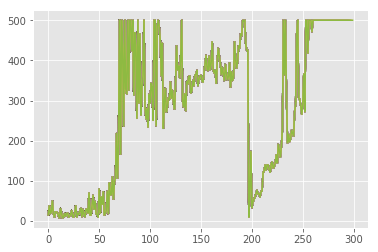

In [4]:
if __name__ == "__main__":
    start = datetime.datetime.now()
    
    graph_path = os.path.join(os.getcwd(), 'save_graph')
    model_path = os.path.join(os.getcwd(), 'save_model')

    if not os.path.isdir(graph_path):
        os.mkdir(graph_path)
    if not os.path.isdir(model_path):
        os.mkdir(model_path)

    # CartPole-v1 환경, 최대 타임스텝 수가 500
    env = gym.make('CartPole-v1')
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n

    # DQN 에이전트 생성
    agent = DQNAgent(state_size, action_size)

    scores, episodes = [], []

    
    # 
    for e in range(EPISODES):
        done = False
        score = 0
        # env 초기화
        state = env.reset()
        state = np.reshape(state, [1, state_size])

        while True:
            if agent.render:
                env.render()
            
            # 1. Q-Learning과 마찬가지로 step단위로 탐험을 수행함 -> sampling
            # 2. 학습을 step단위로 수행함
            
            # 현재 상태로 행동을 선택
            action = agent.get_action(state)
            # 선택한 행동으로 환경에서 한 타임스텝 진행
            next_state, reward, done, info = env.step(action)
            next_state = np.reshape(next_state, [1, state_size])
            # 에피소드가 중간에 끝나면 -100 보상
            reward = reward if not done or score == 499 else -100

            # 리플레이 메모리에 샘플 <s, a, r, s'> 저장
            agent.append_sample(state, action, reward, next_state, done)
            # 매 타임스텝마다 학습
            if len(agent.memory) >= agent.train_start:
                agent.train_model()

            score += reward
            state = next_state
            global_steps += 1

            if done:
                # 각 에피소드마다 타깃 모델을 모델의 가중치로 업데이트
                agent.update_target_model()

                score = score if score == 500 else score + 100
                # 에피소드마다 학습 결과 출력
                scores.append(score)
                episodes.append(e)
                plt.plot(episodes, scores)
                plt.savefig("./save_graph/cartpole_dqn.png")
                print("episode:", e, "  score:", score, "  memory length:", len(agent.memory),
                      "  epsilon:", agent.epsilon, "global steps: ", global_steps)

                # 이전 10개 에피소드의 점수 평균이 490보다 크면 학습 중단

                if np.mean(scores[-min(10, len(scores)):]) > 490:
                    agent.model.save_weights("./save_model/cartpole_dqn.h5")
                    agent.render = True
                else:
                    agent.render = False
                break
    env.close()
    end = datetime.datetime.now()
    elapsed = end - start
    print(elapsed)